In [1]:
import datetime
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ds_atm = xr.open_mfdataset('/glade/scratch/czarakas/archive/COUP0000_1850spinup/atm/hist/*.h1.*.nc')

In [ ]:
ds_atm = xr.open_mfdataset('/glade/scratch/czarakas/archive/COUP0000_1850spinup/atm/hist/*.TREFHT.*.nc')

In [3]:
ds_lnd = xr.open_mfdataset('/glade/scratch/czarakas/archive/COUP0000_1850spinup/lnd/hist/*.h1.*.nc')

# Fix the times 
CESM saves the time as the last time over which something was averaged (e.g. average temperature in January is saved at midnight of Feb 1), so offset by 15 days so the month corresponds to the month over which it was averaged
Only change the time once or else just shifting back 15 days over and over

In [4]:
ds_atm['time']=ds_atm.time.values-datetime.timedelta(days=15)

In [5]:
ds_lnd['time']=ds_lnd.time.values-datetime.timedelta(days=15)

# Calculate area weights

In [6]:
#Atmosphere weights
weight_factor1 = ds_atm.gw / ds_atm.gw.mean(dim='lat')

def atm_weights_region(minlat=-100,maxlat=100):
    gw=ds_atm.gw
    gw=gw.where(gw.lat>=minlat).where(gw.lat<=maxlat)
    return gw/gw.mean(dim='lat')

#Land weights
land_area=ds_lnd.area*ds_lnd.landfrac
landweights = land_area/land_area.sum(dim=['lat','lon'])

#Land weights
def land_weights_region(minlat=-100,maxlat=100):
    land_area=ds_lnd.area*ds_lnd.landfrac
    land_area=land_area.where(land_area.lat>=minlat).where(land_area.lat<=maxlat)
    landweights = land_area/land_area.sum(dim=['lat','lon'])
    return landweights

In [7]:
weight_factor1=weight_factor1.mean(dim='time')

# Check that CO_2 isn't changing over time (it should be constant!) and that it is about the right concentration
Should be ~388.72 (from Meinshausen et al. 2017)
Check this is true for both the atmosphere AND the land
This is ~1.35x pre-industrial concentrations, so if things were linear (which they're not), we should expect global temperature change to be ~0.35x of the equilibrium climate sensitivity. CESM2 has an ECS of 5.3K, so the temperature change should be ~1.85K?

In [ ]:
plt.plot(ds_atm.co2vmr*1e6,'.-')
plt.xlabel('Month of Simulation')
plt.ylabel('CO2 concentration (ppm)')

In [8]:
print(ds_atm.co2vmr.mean(dim='time').values*1e6)

284.7


Text(0, 0.5, 'CO2 concentration (ppm)')

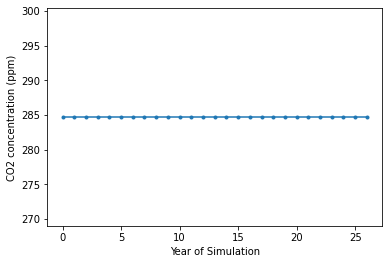

In [9]:
plt.plot(ds_atm.co2vmr.groupby('time.year').mean()*1e6,'.-')
plt.xlabel('Year of Simulation')
plt.ylabel('CO2 concentration (ppm)')

# Look at temperature

In [7]:
tmonths = np.arange(0, np.size(ds_atm.time))/12
tyears = np.arange(0, np.size(ds_atm.time.groupby('time.year').mean(dim='time')))+0.5

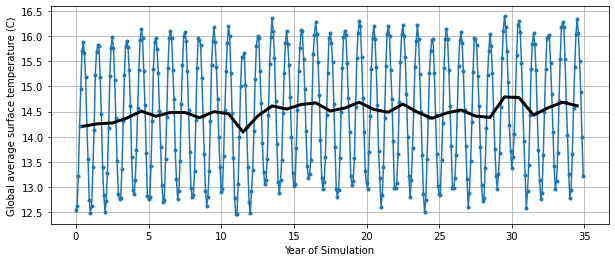

In [8]:
plt.figure(figsize=(10,4))
plt.plot(tmonths, (ds_atm.TREFHT * weight_factor1).mean(dim=('lon', 'lat'))-273.15,'.-')
plt.plot(tyears,(ds_atm.TREFHT * weight_factor1).mean(dim=('lon', 'lat')).groupby('time.year').mean(dim='time')-273.15,
         '-k',linewidth=3)
plt.xlabel('Year of Simulation')
plt.ylabel('Global average surface temperature (C)')
plt.grid()
#plt.xlim([0,20])
plt.savefig('Spinup_global_temperature.png')

In [9]:
global_mean_temp_thiscase= (ds_atm.TREFHT * weight_factor1).mean(dim=('lon', 'lat'))#.groupby('time.year').mean(dim='time')-273.15

# Compare temperature to case we're branching from

In [8]:
mother_case = xr.open_mfdataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001/atm/proc/tseries/month_1/*TREFHT*.nc')
mother_case['time']=mother_case.time.values-datetime.timedelta(days=15)

In [9]:
weight_factor2 = mother_case.gw / mother_case.gw.mean(dim='lat')

In [10]:
mother_case_daily = xr.open_mfdataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001/atm/proc/tseries/day_1/b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001.cam.h1.TSMX.04*.nc')
thiscase_daily=xr.open_mfdataset('/glade/scratch/czarakas/archive/COUP0000_1850spinup/atm/hist/*.h2.*.nc')

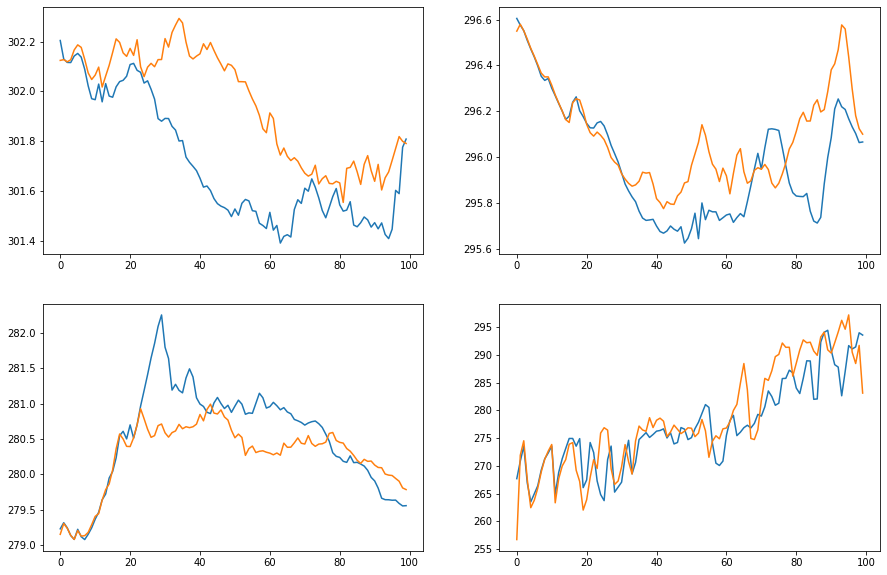

In [7]:
# Compare daily temperatures at a bunch of different points
endt=100
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(mother_case_daily.TSMX[:endt,50,60])
plt.plot(thiscase_daily.TSMX[:endt,50,60])
plt.subplot(2,2,2)
plt.plot(mother_case_daily.TSMX[:endt,60,130])
plt.plot(thiscase_daily.TSMX[:endt,60,130])
plt.subplot(2,2,3)
plt.plot(mother_case_daily.TSMX[:endt,20,30])
plt.plot(thiscase_daily.TSMX[:endt,20,30])
plt.subplot(2,2,4)
plt.plot(mother_case_daily.TSMX[:endt,70,50])
plt.plot(thiscase_daily.TSMX[:endt,70,50])

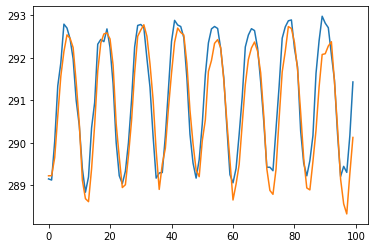

In [19]:
plt.plot((thiscase_daily.TSMX* weight_factor1).mean(dim=('lon', 'lat'))[0:100])
plt.plot((mother_case_daily.TSMX* weight_factor2).mean(dim=('lon', 'lat'))[0:100])

In [14]:
ds_atm_global=(ds_atm.TREFHT* weight_factor1).mean(dim=('lon', 'lat')).groupby('time.year').mean(dim='time').load()
mother_case_global=(mother_case.TREFHT* weight_factor2).mean(dim=('lon', 'lat')).groupby('time.year').mean(dim='time').load()[400:]


In [15]:
ds_SOM=xr.open_mfdataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlopeExperiments2021/archive/spinup_coupled/coupled_DEFmedslope_1xCO2_02_old/tseries/'+
                           '*TREFHT*.nc')
ds_SOM['time']=ds_SOM.time.values-datetime.timedelta(days=15)

In [22]:
ds_SOM_global=(ds_SOM.TREFHT*weight_factor1).mean(dim=('lon', 'lat')).groupby('time.year').mean(dim='time').load()

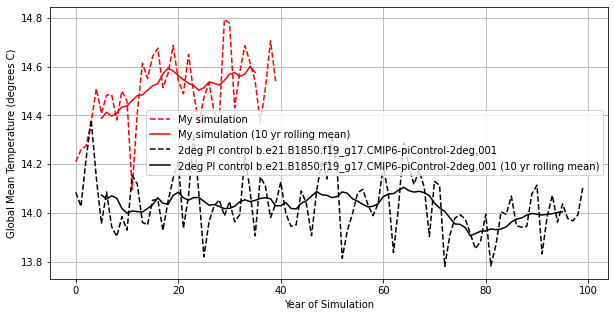

In [31]:
plt.figure(figsize=(10,5))
plt.plot(ds_atm_global-273.15,'--r', label='My simulation')
plt.plot(ds_atm_global.rolling(year=10,center=True).mean()-273.15,'-r', label='My simulation (10 yr rolling mean)')
#plt.plot(ds_SOM_global-273.15,':r', label='My simulation')
plt.plot(mother_case_global-273.15,'--k',label='2deg PI control b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001')
plt.plot(mother_case_global.rolling(year=10,center=True).mean()-273.15,'-k',label='2deg PI control b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001 (10 yr rolling mean)')
plt.xlabel('Year of Simulation')
plt.ylabel('Global Mean Temperature (degrees C)')
plt.legend()
plt.grid()

In [ ]:
ds_check=xr.open_mfdataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlopeExperiments2021/archive/coupled/coupled_DEFmedslope_1xCO2_03/atm/hist/'+
                           'coupled_DEFmedslope_1xCO2_03.cam.h0.007*.nc')

# Look at vegetation fluxes

In [14]:
var='TLAI'

In [15]:
mother_totvegc=xr.open_mfdataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f19_g17.CMIP6-piControl-2deg.001/lnd/proc/tseries/month_1/*.h0.'+var+'.*.nc')
other_exp = xr.open_mfdataset('/glade/campaign/univ/uwas0044/czarakas/StomatalSlopeExperiments2021/archive/spinup_coupled/coupled_DEFmedslope_1xCO2_02_old/tseries/*'+var+'*.nc')
landonly_finidat_check=xr.open_mfdataset('/glade/scratch/czarakas/archive/landonly_test0001/lnd/hist/*.nc')

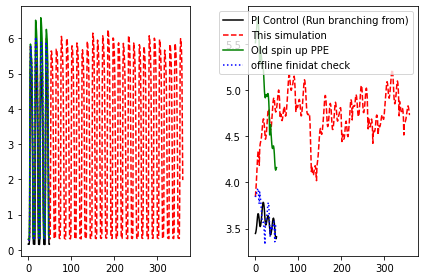

In [16]:
plt.subplot(1,2,1)
ilat=70
ilon=50
plt.plot(mother_totvegc[var][400*12:400*12+50,ilat,ilon],'-k')
plt.plot(ds_lnd[var][:,ilat,ilon],'--r')
plt.plot(other_exp[var][:50,ilat,ilon],'-g')
plt.plot(landonly_finidat_check[var][:50,ilat,ilon],':b',label='offline finidat check')
plt.subplot(1,2,2)
ilat=45
ilon=120
plt.plot(mother_totvegc[var][400*12:400*12+50,ilat,ilon],'-k',label='PI Control (Run branching from)')
plt.plot(ds_lnd[var][:,ilat,ilon], '--r',label='This simulation')
plt.plot(other_exp[var][:50,ilat,ilon],'-g', label='Old spin up PPE')
plt.plot(landonly_finidat_check[var][:50,ilat,ilon],':b',label='offline finidat check')
plt.legend()
plt.tight_layout()

In [78]:
thiscase_daily_global = (thiscase_daily.TREFHTMX*weight_factor1).mean(dim=['lat','lon'])

AttributeError: 'Dataset' object has no attribute 'TREFHT'

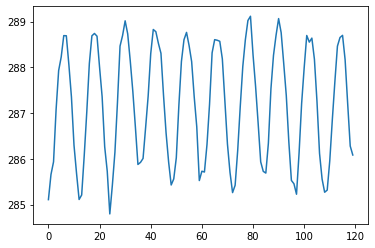

In [75]:
plt.plot(global_mean_daily)
plt.plot(np.arange(0,np.size(

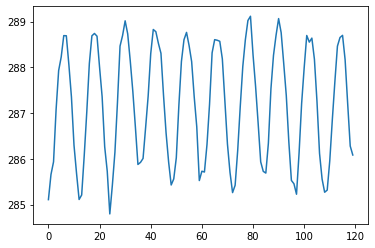

In [73]:
plt.plot(global_mean_daily)

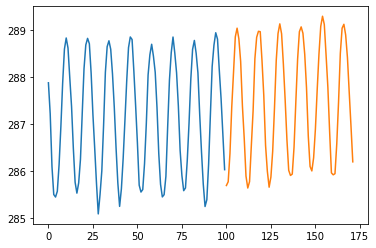

In [46]:
comparison = global_mean_temp[5900:6000]
time_comparison = np.arange(0,np.size(comparison))
time_thiscase=np.arange(np.size(comparison), np.size(comparison)+np.size(global_mean_temp_thiscase))
                  
plt.plot(time_comparison, comparison)
plt.plot(time_thiscase, global_mean_temp_thiscase)
#plt.plot()

In [31]:
global_mean_temp_annual = global_mean_temp.groupby('time.year').mean(dim='time')[:-1]-273.15

In [70]:
global_mean_temp[400*12-100:400*12+100][100]

<xarray.DataArray ()>
array(285.84003557)
Coordinates:
    time     object 0401-01-17 00:00:00

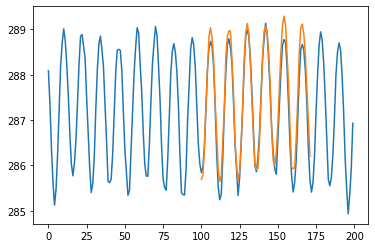

In [72]:
plt.plot(global_mean_temp[400*12-100:400*12+100])
plt.plot(np.arange(100,6*12+100), global_mean_temp_thiscase)

(300.0, 450.0)

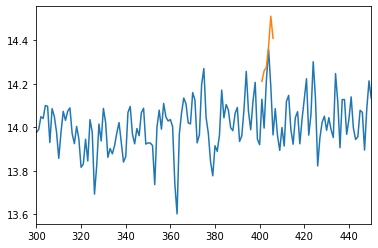

In [56]:
plt.plot(global_mean_temp_annual.year, global_mean_temp_annual)
plt.plot(400+global_mean_temp_thiscase_annual.year, global_mean_temp_thiscase_annual)
plt.xlim([300,450])

# Look at atmospheric quantities in different latitudinal belts

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


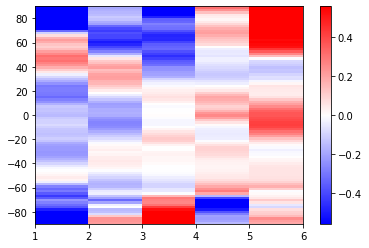

In [17]:
var = 'TREFHT'
yr_spin_up_done=0
var_series = ds_atm[var]-273.15

var_zonal_mean = var_series.mean(dim='lon')
var_zonal_mean = var_zonal_mean.groupby('time.year').mean(dim='time')
var_zonal_mean=var_zonal_mean[yr_spin_up_done:,:]
var_zonal_mean = var_zonal_mean - var_zonal_mean.mean(dim='year')
cbound = np.max(np.abs([np.nanpercentile(var_zonal_mean,95),np.nanpercentile(var_zonal_mean,5)]))
plt.pcolor(var_zonal_mean.year, var_zonal_mean.lat, var_zonal_mean.transpose(), cmap=plt.cm.bwr,
          vmin=-cbound, vmax=cbound)#, tlai_zonal_mean.time, tlai_zonal_mean.lat)
#plt.ylim([-90,90])
plt.colorbar()

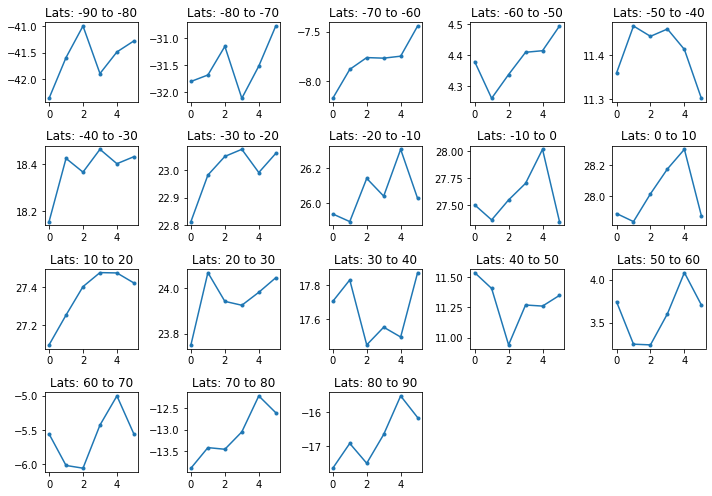

In [13]:
latrange_min=-90
dlat=10
plt.figure(figsize=(10,7))
for i in np.arange(0,int(180/dlat)):
    latmin=latrange_min+(dlat*i)
    latmax=latrange_min+(dlat*(i+1))
    weights_region=atm_weights_region(minlat=latmin,maxlat=latmax)
    label="Lats: "+str(latmin)+" to "+str(latmax)
    annual_var=(ds_atm.TS*weights_region).mean(dim=['lat','lon']).groupby('time.year').mean(dim='time')-273.15
    plt.subplot(4,5,i+1)
    plt.plot(annual_var,'.-')
    plt.title(label)
    #plt.ylim([0,np.nanmax(annual_LAI)*1.2])
plt.tight_layout()

# Look at global average LAI

Text(0, 0.5, 'Global average LAI')

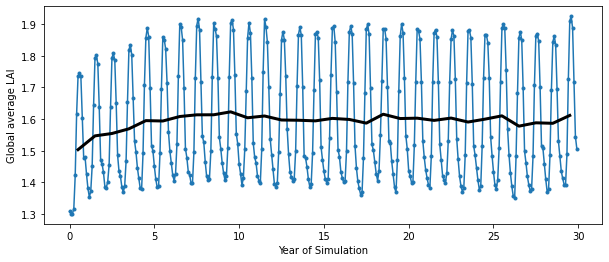

In [19]:
plt.figure(figsize=(10,4))
plt.plot(tmonths, 
         (ds_lnd.TLAI*landweights).sum(dim=['lat','lon']),
         '.-')
plt.plot(tyears,
         (ds_lnd.TLAI*landweights).sum(dim=['lat','lon']).groupby('time.year').mean(dim='time'),
         '-k',linewidth=3)
plt.xlabel('Year of Simulation')
plt.ylabel('Global average LAI')

# Look at land quantities in different latitudinal belts

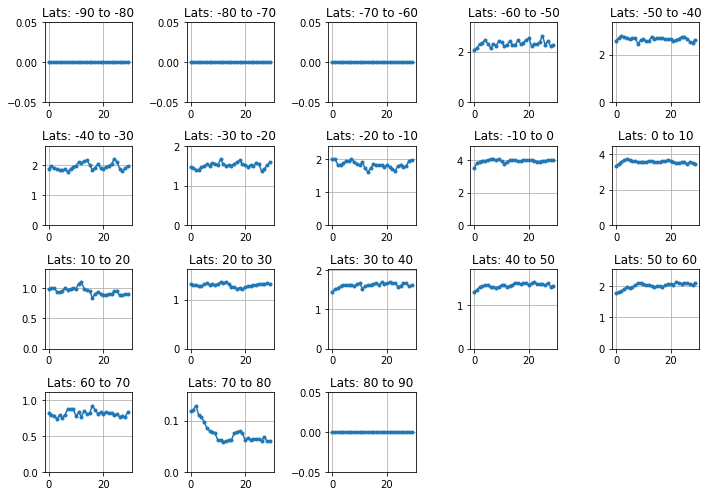

In [20]:
latrange_min=-90
dlat=10
plt.figure(figsize=(10,7))
for i in np.arange(0,int(180/dlat)):
    latmin=latrange_min+(dlat*i)
    latmax=latrange_min+(dlat*(i+1))
    landweights_region=land_weights_region(minlat=latmin,maxlat=latmax)
    label="Lats: "+str(latmin)+" to "+str(latmax)
    annual_mean=(ds_lnd.TLAI*landweights_region).sum(dim=['lat','lon']).groupby('time.year').mean(dim='time')
    plt.subplot(4,5,i+1)
    plt.plot(annual_mean,'.-')
    plt.title(label)
    if np.nanmax(annual_mean)<0.01:
        plt.ylim([-0.05,0.05])
    else:
        plt.ylim([np.nanmin(annual_mean)*0.,np.nanmax(annual_mean)*1.2])
    plt.grid()
plt.tight_layout()

(-90.0, 90.0)

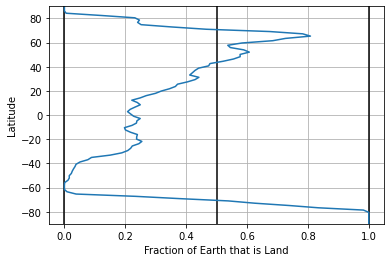

In [15]:
landfrac_full = ds_lnd.landfrac.fillna(0)[0,:,:]
plt.plot([0,0],[-90,90],'-k')
plt.plot([0.5,0.5],[-90,90],'-k')
plt.plot([1,1],[-90,90],'-k')
plt.plot(landfrac_full.mean(dim='lon'),ds_lnd.lat)
plt.grid()
plt.xlabel('Fraction of Earth that is Land')
plt.ylabel('Latitude')
plt.ylim([-90,90])